## **Evaluator-Optimizer Workflow**


In [1]:
from typing_extensions import TypedDict, Literal, Annotated, List
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Pydantic schema
class llm_schema(BaseModel):
    funny_flag: Literal["funny", "not_funny"] = Field(
        description="Whether the joke is funny or not")

    feedback: str = Field(description="Feedback on the joke")

In [3]:
llm = ChatGroq(model="llama-3.1-8b-instant")

schema_llm = llm.with_structured_output(llm_schema)

In [4]:
# graph schema
class graph_schema(TypedDict):

    topic: str
    joke: str
    funny_flag: str
    feedback: str
    max_iterations: int

In [5]:
# Nodes

def generate_node(state: graph_schema) -> graph_schema:

    topic = state['topic']

    if state['feedback']:  # Not first iteration, generate a joke based on feedback
        response = llm.invoke(
            f"""
            Rewrite this joke to make it funnier.
            Return only the improved joke.

            Joke: {state['joke']}
            Feedback: {state['feedback']}
                """)

    else:  # First iteration, generate a joke
        response = llm.invoke(
            "Create only one joke about the following topic: " + topic)

    state['joke'] = response.content
    return state


def evaluate_node(state: graph_schema) -> graph_schema:

    joke = state['joke']
    iteration = state['max_iterations']

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a comedy critic. Your job is to evaluate the following joke and provide feedback on how to make it funnier."),
        ("user",
         f"Evaluate the following joke: {joke}\nRespond with 'funny' or 'not_funny' and provide feedback if it's not funny.")
    ])

    chain = prompt | schema_llm
    response = chain.invoke({"joke": joke})

    state['funny_flag'] = response.funny_flag
    state['feedback'] = response.feedback

    state['max_iterations'] += 1

    return state

In [6]:
# conditional edge
def check_iteration(state: graph_schema):
    if state["max_iterations"] < 5 and state["funny_flag"] != "funny":
        return "generate_node"

    return "end"

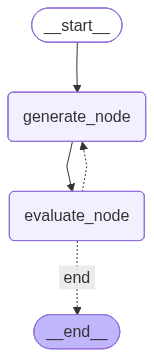

In [7]:
# building graph
graph = StateGraph(graph_schema)

graph.add_node("generate_node", generate_node)
graph.add_node("evaluate_node", evaluate_node)

graph.add_edge(START, "generate_node")
graph.add_edge("generate_node", "evaluate_node")

graph.add_conditional_edges("evaluate_node", check_iteration,
                            {
                                "generate_node": "generate_node", "end": END
                            }
                            )


evaluator_graph = graph.compile()
evaluator_graph

In [8]:
for chunk in evaluator_graph.stream(
    {
        "topic": "Cars",
        "joke": "",
        "funny_flag": "",
        "feedback": "",
        "max_iterations": 0
    },
    stream_mode="updates"
):
    print(chunk)

{'generate_node': {'topic': 'Cars', 'joke': 'Why did the car go to the doctor? \n\nBecause it was feeling a little "car-sick."', 'funny_flag': '', 'feedback': '', 'max_iterations': 0}}
{'evaluate_node': {'topic': 'Cars', 'joke': 'Why did the car go to the doctor? \n\nBecause it was feeling a little "car-sick."', 'funny_flag': 'not_funny', 'feedback': "The joke has a good start with a play on words, but it might not be immediately clear for everyone. To make it funnier, consider adding more context or a punchline that ties in with the car-sickness pun. For example, you could add something like 'The doctor gave it some motion sickness meds, and it was back on the road in no time!'", 'max_iterations': 1}}
{'generate_node': {'topic': 'Cars', 'joke': 'Why did the car go to the doctor? Because it was feeling a little "car-sick". The doctor gave it some motion sickness meds, and it was back on the road in no time – now it\'s just \'driven\' to recover!', 'funny_flag': 'not_funny', 'feedback':

In [10]:
print(chunk["evaluate_node"]["joke"])

Why did the car go to the doctor? Because it was feeling a little "car-sick". The doctor gave it some motion sickness meds, and it was back on the road in no time – now it's just 'driven' to recover!
